# Zestaw 6. Układy równań liniowych

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1. Metoda Gaussa-Jordana

<i> Napisz i sprawdź funkcję rozwiązującą układ równań liniowych n × n metodą Gaussa-Jordana. </i> 

In [48]:
def gauss_jordan(A, B):
    n = A.shape[0]
    A = A.copy()
    B = B.copy()
    for i in range(n):
        print(A)
        print(B)
        p = i
        while p < n and A[p, i] == 0:
            p += 1
            
        if p == n:
            print('no solution')
            return
    
        A[[p, i]] = A[[i, p]]
        B[[p, i]] = B[[p, i]]
        
        for j in range(n):
            if j != i:
                A[j,:] -= (A[j, i]/A[i, i])*A[i,:]
                B[j] -= (A[j, i]/A[i, i])*B[i]
                
            else:
                A[j, :] /= (A[j, i]/A[i, i])
                B[j] /= (A[j, i]/A[i, i])
            
        
    return B

In [49]:
A = np.array([[1,1,1], [1,2,3], [3,2,1]], dtype=float)
B = np.array([3, 6, 6], dtype=float)
print(gauss_jordan(A, B))

[[1. 1. 1.]
 [1. 2. 3.]
 [3. 2. 1.]]
[3. 6. 6.]
[[ 1.  1.  1.]
 [ 0.  1.  2.]
 [ 0. -1. -2.]]
[3. 6. 6.]
[[ 1.  0. -1.]
 [ 0.  1.  2.]
 [ 0.  0.  0.]]
[3. 6. 6.]
no solution
None


<i>Dla rozmiarów macierzy współczynników większych niż 500 × 500 porównaj czasy działania zaimplementowanej funkcji z czasami uzyskanymi dla wybranych funkcji bibliotecznych. Opisz wyniki i podaj zalety i wady w stosunku do metody eliminacji Gaussa.
</i>

## 2. Faktoryzacja LU

<i>1. Zaimplementuj i sprawdź funkcję dokonującą faktoryzacji A = LU macierzy A. Zastosuj częściowe poszukiwanie elementu wiodącego oraz skalowanie. Sprawdź wyniki.</i>

<i>2. Opisz w jaki sposób faktoryzacja LU może być wykorzystana do rozwiązywania układów równań liniowych i zaimplementuj rozwiązanie. Porównaj wyniki z funkcją biblioteczną.</i>

## 3. Przekształcenie sfery w elipsoidę

1. Korzystając z równania parametrycznego narysuj sferę jednostkową w 3D cos(s) sin(t)  v =  sin(s) sin(t) cos(t) s ∈ [0, 2π], t ∈ [0, π]

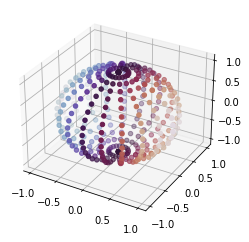

In [73]:
ss = np.linspace(0, 2*np.pi, 20)
ts = np.linspace(0, np.pi, 20)

x_axis = []
y_axis = []
z_axis = []

for s in ss:
    for t in ts:
        x_axis.append(np.cos(s)*np.sin(t))
        y_axis.append(np.sin(s)*np.sin(t))
        z_axis.append(np.cos(t))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(x_axis), np.array(y_axis), np.array(z_axis), c=x_axis, cmap=plt.get_cmap('twilight'))
plt.show()

2. Wygeneruj 3 różne macierze A 1 , A 2 , A 3 , (A i ∈ R 3×3 ), za ich pomocą dokonaj przekształcenia sfery w elipsoidę, a następnie przedstaw wizualizację uzyskanego wyniku.

3. Dokonaj rozkładu według wartości osobliwych (SVD) każdej macierzy A i . Na wykresie elipsoidy odpowiadającej przekształceniu A i dodaj wizualizację jej półosi wyznaczonych za pomocą SVD.

In [66]:
# svd - z funkcji bibliotecznej

4. Znajdź taką macierz A i , aby stosunek jej największej i najmniejszej wartości osobliwej był większy od 100. Narysuj odpowiadającą jej elipsoidę. Czym charakteryzuje się wygenerowana elipsoida i czemu tak się dzieje?

In [68]:
# losowa -> svd -> modyfikujemy sigma, 
# żeby coś tam było największe i mnożymy z powrotem

5. Dla wybranej macierzy A i przedstaw wizualizacje SV i T , SΣ i V i T oraz SU i Σ i V i T,gdzie A i = U i Σ i V i T , a S oznacza sferę z punktu 1. Opisz jakie przekształcenia mają miejsce w kolejnych krokach.

## 4. Układ źle uwarunkowany

In [75]:
# poczytać kincaida - strona 321

1. Rozwiąż układ równań
> 0.835x + 0.667y = 0.168
> 0.333x + 0.266y = 0.067

2. Zaburz delikatnie rozwiązanie zmieniając wartość 0.067 na 0.066 i rozwiąż ponownie. Czemu wyniki się znacząco różnią?

3. Używając rozkładu SVD na macierzy współczynników znajdź stosunek maksymalnej do minimalnej wartości osobliwej. Porównaj to z wartościami wygenerowanymi
dla 3 losowych macierzy tego samego rozmiaru i opisz wyniki.

In [77]:
# napisać o co chodzi z kappą

## Wnioski

M. Hawryluk 22.04.2021